In [5]:
import os
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot
%matplotlib inline

In [6]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient
        
        
def define_panels(x, y, N):
    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    return panels


class Freestream:
    def __init__(self, u_inf, alpha):
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians
        
        
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]


def source_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, panel_j,numpy.cos(panel_i.beta),numpy.sin(panel_i.beta))
    return A


def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A


def kutta_condition(A_source, B_vortex):
    b = numpy.empty([2,A_source.shape[1]+2],dtype=float)
    b[0,:-2] = B_vortex[0, :] + B_vortex[N-1, :]
    b[1,:-2] = B_vortex[N, :] + B_vortex[2*N-1, :]
    
    b[-2,-2]=- numpy.sum(A_source[0,:N] + A_source[N-1,:N])
    b[-2,-1]=- numpy.sum(A_source[0,N:] + A_source[N-1,N:])
    b[-1,-2]=- numpy.sum(A_source[N,:N] + A_source[2*N-1,:N])
    b[-1,-1]=- numpy.sum(A_source[N,N:] + A_source[2*N-1,N:])
    
    return b


def build_singularity_matrix(A_source, B_vortex):
    A = numpy.empty((A_source.shape[0]+2, A_source.shape[0]+2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = numpy.sum(B_vortex[:,:N], axis=1)    
    A[:-2, -1] = numpy.sum(B_vortex[:,N:], axis=1)
    # Kutta condition array
    A[-2:, :] = kutta_condition(A_source, B_vortex)
    return A


def build_freestream_rhs(panels, freestream):
    b = numpy.empty(panels.size+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[N-1].beta) )
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[N].beta)
                               +numpy.sin(freestream.alpha-panels[2*N-1].beta) )
    return b


def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

        
def compute_tangential_velocity(panels, freestream, gamma_m,gamma_f, A_source, B_vortex):
    A = numpy.empty((panels.size, panels.size+2), dtype=float)
    A[:, :-2] = B_vortex
    A[:, -2] = -numpy.sum(A_source[:,:N], axis=1)
    A[:, -1] = -numpy.sum(A_source[:,N:], axis=1)
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    strengths = numpy.append([panel.sigma for panel in panels],gamma_m)
    strengths = numpy.append(strengths,gamma_f)
    tangential_velocities = numpy.dot(A, strengths) + b
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        

def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [7]:
x_m, y_m=numpy.loadtxt("resources/MainFoil_N=100.csv",dtype=float,delimiter=',',unpack=True)
x_f,y_f=numpy.loadtxt("resources/FlapFoil_N=100.csv",dtype=float,delimiter=',',unpack=True)

x=numpy.append(x_m,x_f)
y=numpy.append(y_m,y_f)

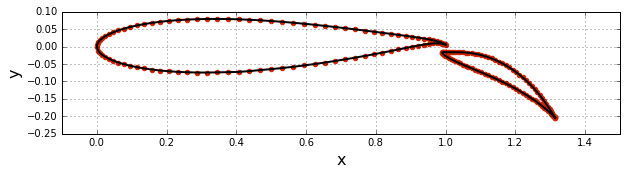

In [8]:
N,u_inf,alpha=len(x_m)-1,1,0
freestream = Freestream(u_inf,alpha)
panels_m = define_panels(x_m, y_m, N)
panels_f = define_panels(x_f, y_f, N)

# plot discretized geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_m, y_m,x_f,y_f,color='k', linestyle='-', linewidth=2)
pyplot.scatter([panel.xa for panel in panels_m],[panel.ya for panel in panels_m],color='#CD2305')
pyplot.scatter([panel.xa for panel in panels_f],[panel.ya for panel in panels_f],color='#CD2305')
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.5)
pyplot.ylim(-0.25, 0.1);

In [9]:
panels=numpy.empty(N*2, dtype=object)
for i in range(N*2):
    if i<N:
        panels[i]=panels_m[i]
    elif i>=N:
        panels[i]=panels_f[i-N]

A_source=source_contribution_normal(panels)
B_vortex= vortex_contribution_normal(panels)

In [10]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels,freestream)
strengths = numpy.linalg.solve(A, b)
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
gamma_m = strengths[-2]
gamma_f = strengths[-1]

compute_tangential_velocity(panels, freestream, gamma_m,gamma_f, A_source, B_vortex)
compute_pressure_coefficient(panels, freestream)

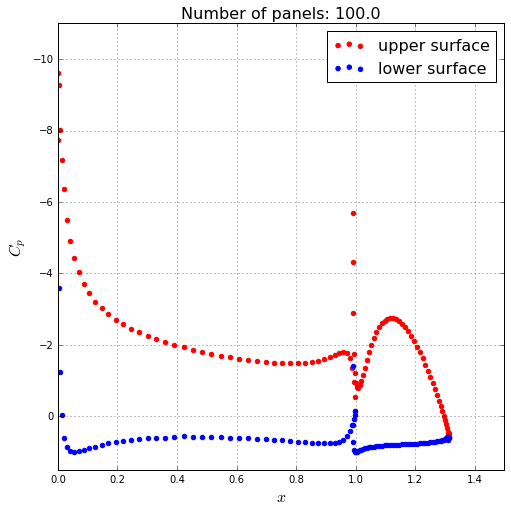

In [28]:
# plot surface pressure coefficient
pyplot.figure(figsize=(8, 8))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.scatter([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',color='r')
pyplot.scatter([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',color='b')
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0, 1.5)
pyplot.ylim(-11, 1.5)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels: {}'.format(panels.size*0.5), fontsize=16);

In [16]:
panels[2].cp

-0.95570117298077895

In [15]:
panels[N+9].cp

-0.27991839836855581

In [36]:
Lift_1,Drag_1=0,0
for panel in panels:
    Lift_1 -=panel.cp*numpy.sin(panel.beta)*panel.length
    Drag_1 +=panel.cp*numpy.cos(panel.beta)*panel.length

In [37]:
Lift_1

3.6977144768607491

In [39]:
Drag_1

0.010791403245870792

In [40]:
lift_theoretical=3.7386
absolute_error_1=abs(Lift_1-lift_theoretical)
print('absolute error of 100 panels is ',absolute_error_1)

absolute error of 100 panels is  0.0408855231393
